In [1]:
import numpy as np

import random
from scipy import integrate
from scipy import interpolate
from scipy import stats
import matplotlib.pylab as plt
from matplotlib import cm
from matplotlib.ticker import AutoMinorLocator
% matplotlib notebook
import glob
import scipy
from IPython.display import Image

def plot_style(xticks=5,yticks=5):
    
    global ax,fig
    
    plt.rc('text', usetex=True)
    #plt.rcParams['mathtext.fontset'] = 'cm'
    #plt.rcParams['mathtext.rm'] = 'serif'
    plt.rcParams.update({'figure.autolayout': True})
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['axes.linewidth'] = 2
    plt.rcParams['figure.figsize'] = 8, 7.5

    fig,ax = plt.subplots()
    x_minor_locator = AutoMinorLocator(xticks)
    y_minor_locator = AutoMinorLocator(yticks)
    plt.tick_params(which='both', width=1.7)
    plt.tick_params(which='major', length=9)
    plt.tick_params(which='minor', length=5)
    ax.xaxis.set_minor_locator(x_minor_locator)
    ax.yaxis.set_minor_locator(y_minor_locator)
    ax.tick_params(axis='both', which='both', pad=8, left='on', right='on',top='on',bottom='on')

    plt.rcParams['lines.linewidth'] = 1.0
    plt.rcParams['lines.dashed_pattern'] = [6, 6] 
    plt.rcParams['lines.dashdot_pattern'] = [3, 5, 1, 5]
    plt.rcParams['lines.dotted_pattern'] = [1, 3]
    plt.rcParams['lines.scale_dashes'] = False
    plt.rcParams['errorbar.capsize'] = 6

# Loading NS model's data

In [2]:
MSun = 1.98892e33  

_star_model = np.loadtxt('x_rho_nb_ne_nn.dat', skiprows=1)

_rho = interpolate.interp1d(np.log10(_star_model[:, 0]), np.log10(_star_model[:, 1]), kind='cubic',bounds_error=False,fill_value=-50)
_nb = interpolate.interp1d(np.log10(_star_model[:, 0]), _star_model[:, 2], kind='cubic',bounds_error=False,fill_value=0.0)
_ne = interpolate.interp1d(np.log10(_star_model[:, 0]), _star_model[:, 3], kind='cubic',bounds_error=False,fill_value=0.0)
_nn = interpolate.interp1d(np.log10(_star_model[:, 0]), _star_model[:, 4], kind='cubic',bounds_error=False,fill_value=0.0)


def rho(a):  # density(radius)     
    return np.power(10,_rho(np.log10(a)))

def nb(a):   # baryon number density(radius)
    return _nb(np.log10(a))

def ne(a):   # electron number density(radius)
    return _ne(np.log10(a))
 
def nn(a):   # muon number density(radius)
    return _nn(np.log10(a))

In [3]:
def integrate(function, grid, axis_number):
    result = np.trapz(function, grid, axis=axis_number)
    return result

def gradient(function, grid, axis_number):
    return np.gradient(function,grid, axis=axis_number,edge_order=2)

# INITIAL MAGNETIC FIELD $B$ ( see page 11, “Minimal” model of the magnetic field )

In [4]:
# some constants which at this stage do not really matter

R = 12.178e5 # cm
c = 3e10 
e = 4.803e-10
B_max = 5e15

def delta(i,j): # the Kronecker delta
    return i==j

In [5]:
def Psy(x,theta): # eq. 48
    return B_max*R*R* (1./2. * x*x - 3./5. * np.power(x,4) + 3./14. * np.power(x,6) ) * np.power(np.sin(theta),2)

In [6]:
def grad_Psy(x, theta, i):
    psy_r = B_max*R* (x - 12./5. * np.power(x,3) + 18./14. * np.power(x,5) ) * np.sin(theta) * np.sin(theta)
    psy_theta = B_max*R* (1./2. * x - 3./5. * np.power(x,3) + 3./14. * np.power(x,5) )* 2 * np.cos(theta) * np.sin(theta)
    return psy_r * delta(1,i) + psy_theta * delta(2,i)

def grad_phi(x, theta ,i):
    return 1./x/R * delta(3,i) / np.sin(theta)

def B_sph(x, theta): # magnetic field B in spherical coordinates' basis
    B_r = grad_Psy(x, theta, 2) * grad_phi(x, theta ,3)
    B_theta = -grad_Psy(x, theta, 1) * grad_phi(x, theta ,3)
    return B_r,B_theta,0.0

def B_cart(x, theta): # magnetic field B in Cartesien coordinates' basis
    B = B_sph(x, theta)
    B_x = np.sin(theta)*B[0] + np.cos(theta)*B[1]  
    B_z = np.cos(theta)*B[0] - np.sin(theta)*B[1]  
    return B_x,0.0,B_z

Creating two meshes: the first (more refined) one stands for the following calculations and the second one is only for visualization purposes

In [106]:
# main grid
N = 300

r = np.linspace(0.01,0.915,N)
theta = np.linspace(0.001,0.999*np.pi,N)
r_grid,theta_grid = np.meshgrid(r,theta)
r = r_grid.flatten()
theta = theta_grid.flatten()

z_grid = r_grid*np.cos(theta_grid)
x_grid = r_grid*np.sin(theta_grid)

z = r*np.cos(theta)
x = r*np.sin(theta)

# additional grid (only for visualization purposes)
N = 20

r2 = np.linspace(0.05,0.915,N)
theta2 = np.linspace(0.001,0.999*np.pi,N)

r2_grid,theta2_grid = np.meshgrid(r2,theta2)

r2 = r2_grid.flatten()
theta2 = theta2_grid.flatten()

z2 = r2*np.cos(theta2)
x2 = r2*np.sin(theta2)

N = int(np.sqrt(len(r)))

<IPython.core.display.Javascript object>


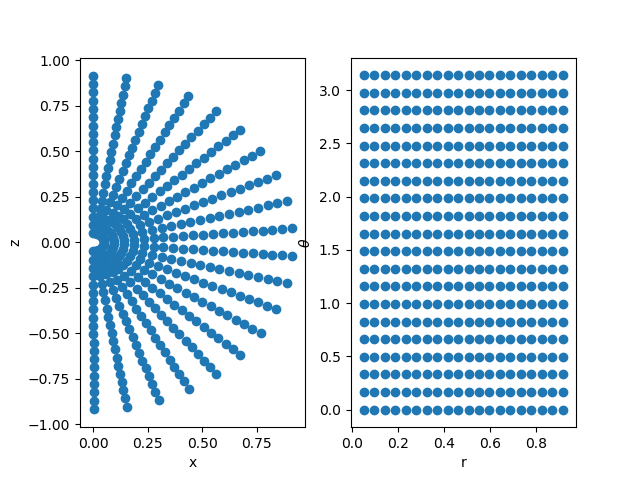

In [107]:
plt.figure()
plt.subplot(1, 2, 1)
plt.scatter(x2,z2)
plt.xlabel('x')
plt.ylabel('z')
plt.subplot(1, 2, 2)
plt.scatter(r2,theta2)
plt.xlabel('r')
plt.ylabel('$\\theta$')
plt.show()

In [108]:
B_ini = np.zeros((3,len(r)))

for i in range(len(r)):
    B_ini[:,i] = B_sph(r[i], theta[i])
    
B_ini_mag = np.sqrt(B_ini[0,:]*B_ini[0,:] + B_ini[1,:]*B_ini[1,:] + B_ini[2,:]*B_ini[2,:])
B_ini_mag_grid = B_ini_mag.reshape((N, N))
print(B_ini_mag)
B_ini_cart_2 = np.zeros((3,len(r2)))
for i in range(len(r2)):
    B_ini_cart_2[:,i] = B_cart(r2[i], theta2[i])

    
print(np.shape(B_ini))
print(np.shape(B_ini_mag))
print(np.shape(B_ini_cart_2))

[4.99940002e+15 4.99898188e+15 4.99845385e+15 ... 1.50556160e+15
 1.49207290e+15 1.47867018e+15]
(3, 90000)
(90000,)
(3, 400)


<IPython.core.display.Javascript object>


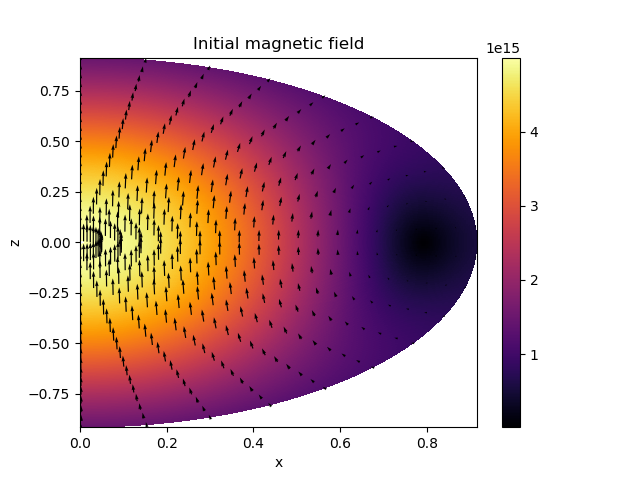

Text(0.5,1,'Initial magnetic field')

In [109]:
plt.figure()
plt.pcolor(x_grid, z_grid, B_ini_mag_grid, cmap=cm.inferno, vmin=B_ini_mag.min(), vmax=B_ini_mag.max())
plt.colorbar()
Q = plt.quiver(x2, z2, B_ini_cart_2[0,:], B_ini_cart_2[2,:], pivot='mid', units='inches')
plt.xlabel('x')
plt.ylabel('z')
plt.title('Initial magnetic field')

# Analytical expressions for the friction coefficients $J_{ep}$ and $J_{np}$ ( from Gusakov 2017, Evolution of the magnetic field in neutron stars, eq 78-79 )

$J_{ep} = 2\times 10^{28} T_8^2 \left(\frac{\rho_0}{\rho}\right)^{5/3} \left(\frac{n_e}{n_0}\right)^{4/3}$ g cm$^{-3}$ s$^{-1}$; 

$J_{np} = 1.25\times 10^{31} T_8^2 \left(\frac{\rho_0}{\rho}\right)^{1/3} \left(\frac{n_p}{n_0}\right)$ g cm$^{-3}$ s$^{-1}$; 

 $n_0 = 0.16$ fm$^{-3}$; $\rho_0 = 2.8 \times 10^{14}$  g cm$^{-3}$; $T_8 = T/(10^{8}$ K)

In [110]:
rho_0 = 2.8e14 # g cm^-3
n_0 = 0.16

def J_ep(T,rho,n_e):
    T8 = T/1e8 # [K]
    return 2.0e28 * T8 * T8 * np.power(rho_0/rho, 5./3.) * np.power(n_e/n_0, 4./3.) # g cm^-3 s^-1

def J_np(T,rho,n_p):
    T8 = T/1e8 # [K]
    return 1.25e31 * T8 * T8 * np.power(rho_0/rho, 1./3.) * n_p/n_0 # g cm^-3 s^-1 

# Number density of five types of particles as a function of radial coordinate of the chosen grid

In [115]:
rho_array = rho(r_grid[0,:])
ne_array = ne(r_grid[0,:])
nb_array = nb(r_grid[0,:])
nn_array = nn(r_grid[0,:])

rho_array_grid = np.zeros_like(r_grid)
ne_array_grid = np.zeros_like(r_grid)
nb_array_grid = np.zeros_like(r_grid)
nn_array_grid = np.zeros_like(r_grid)

for i in range(np.shape(r_grid)[0]):
    rho_array_grid[i,:] = rho_array
    ne_array_grid[i,:] = ne_array
    nb_array_grid[i,:] = nb_array
    nn_array_grid[i,:] = nn_array

np_array_grid = nb_array_grid - nn_array_grid

ne_array_dot_grid = gradient(ne_array_grid,r_grid[0,:]*R, axis_number=1)
nb_array_dot_grid = gradient(nb_array_grid,r_grid[0,:]*R, axis_number=1)

<IPython.core.display.Javascript object>


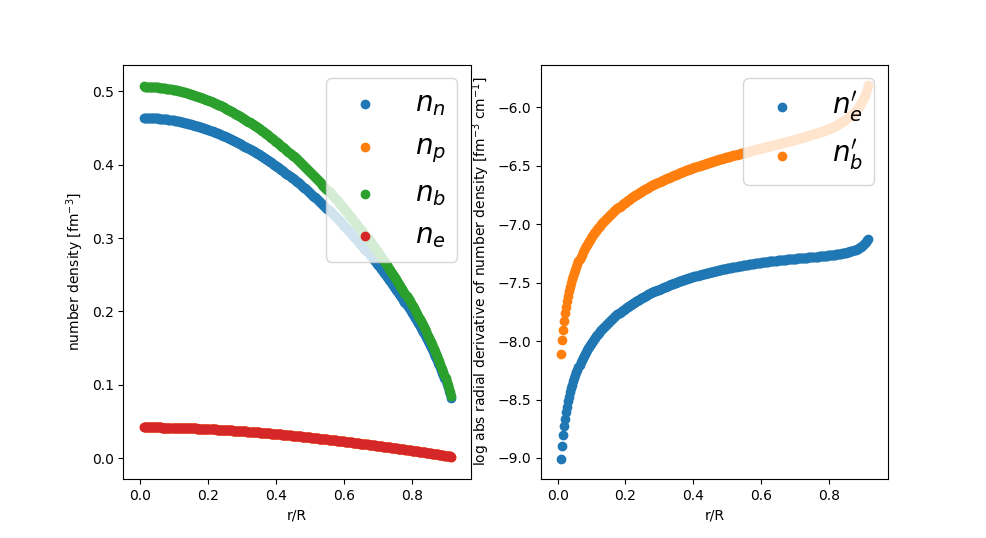

In [120]:
plt.figure()
plt.subplot(1,2,1)
plt.scatter(r_grid[0,:],nn_array_grid[0,:],label='$n_n$')
plt.scatter(r_grid[0,:],np_array_grid[0,:],label='$n_p$')
plt.scatter(r_grid[0,:],nb_array_grid[0,:],label='$n_b$')
plt.scatter(r_grid[0,:],ne_array_grid[0,:],label='$n_e$')

plt.legend(fontsize=20, loc='upper right')
plt.xlabel('r/R')
plt.ylabel('number density [fm$^{-3}$]')

plt.subplot(1,2,2)
plt.scatter(r_grid[0,:],np.log10(np.abs(ne_array_dot_grid[0,:])),label='$n_e\'$')
plt.scatter(r_grid[0,:],np.log10(np.abs(nb_array_dot_grid[0,:])),label='$n_b\'$')
plt.xlabel('r/R')
plt.ylabel('log abs radial derivative of number density [fm$^{-3}$ cm$^{-1}$]')
plt.legend(fontsize=20, loc='upper right')

# Here we take curl of the initial magnetic field and calculate the current $\mathbf{j} = \frac{c}{4 \pi} curl (\mathbf{B}) = \frac{c}{4 \pi}\frac{1}{r}(\frac{\partial}{\partial r}(rB_\theta) - \frac{\partial B_r}{\partial \theta})\mathbf{e}_\varphi$

In [121]:
B_ini_r_grid = B_ini[0,:].reshape((N, N))
B_ini_theta_grid = B_ini[1,:].reshape((N, N))

B_r_grad_theta_grid = np.zeros_like(B_ini_r_grid)
rB_theta_grad_r_grid = np.zeros_like(B_ini_r_grid)
  
rB_theta_grad_r_grid = gradient(r_grid*B_ini_theta_grid, r_grid[0,:], axis_number=1)
B_r_grad_theta_grid = gradient(B_ini_r_grid, theta_grid[:,0], axis_number=0) 

curl_B_grid = (rB_theta_grad_r_grid - B_r_grad_theta_grid)/R/r_grid # curl B is pointing along the \phi-th direction

j_grid = curl_B_grid * c / 4 / np.pi

<IPython.core.display.Javascript object>


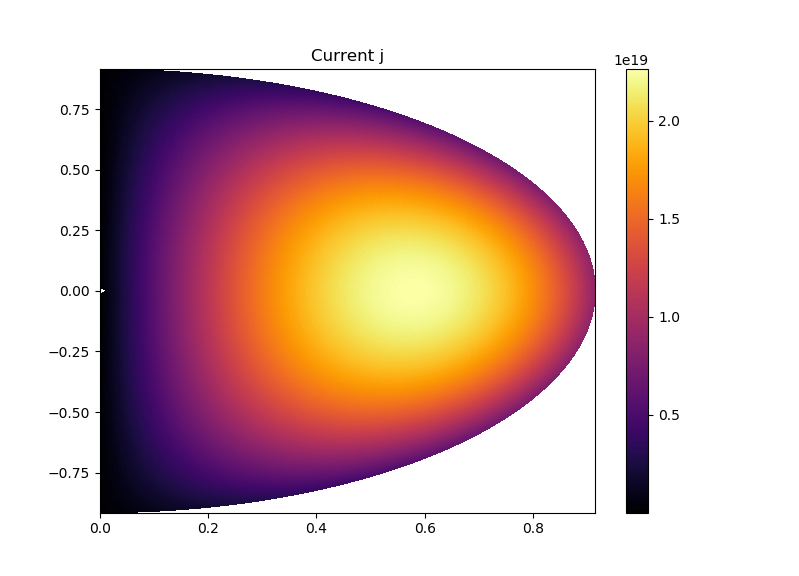

In [122]:
plt.figure()
plt.pcolor(x_grid, z_grid, j_grid, cmap=cm.inferno)
plt.title('Current j')
plt.colorbar()

# the Ampere force $f_A = \frac{1}{c} [j\times B]$;       $f_{Ar} = -\frac{1}{c}jB_\theta$,   $f_{A\varphi} = 0$,  $f_{A\theta} = \frac{1}{c}jB_r$

In [123]:
f_Ar_grid = -j_grid*B_ini_theta_grid / c
f_Atheta_grid = j_grid*B_ini_r_grid / c

# Calculating $r\int_0^\theta f_{A\theta} d\theta$ and $\frac{\partial}{\partial r}( r\int_0^\theta f_{A\theta} d\theta) - f_{Ar}$; we assume $\zeta(r) = 0$ (page 6, eq 23a and 23b)

In [124]:
integral = np.zeros_like(f_Ar_grid)

for i in range(N):
    integral[i,:] = integrate(f_Atheta_grid[:i+1,:], theta_grid[:i+1,0], axis_number=0)
    
eq23a = R*r_grid*integral
eq23b =  gradient(r_grid*integral,r_grid[0,:],axis_number=1) - f_Ar_grid

# Finally we are able to compute $\delta \mu_n$ and $\Delta \mu$

$\begin{pmatrix}
n_b & n_e \\
n_b' & n_e' \\
\end{pmatrix} 
\begin{pmatrix} \delta \mu_n \\ \Delta \mu \end{pmatrix} = 
\begin{pmatrix}
r\int_0^\theta f_{A\theta} d\theta \\
\frac{\partial}{\partial r}( r\int_0^\theta f_{A\theta} d\theta) - f_{Ar} \\
\end{pmatrix}, \quad \begin{pmatrix} \delta \mu_n \\ \Delta \mu \end{pmatrix} =  \frac{1}{n_b n_e' - n_e n_b'} \begin{pmatrix}
n_e' & -n_e \\
-n_b' & n_b \\
\end{pmatrix}\begin{pmatrix}
r\int_0^\theta f_{A\theta} d\theta \\
\frac{\partial}{\partial r}( r\int_0^\theta f_{A\theta} d\theta) - f_{Ar} \\
\end{pmatrix}$

In [125]:
det = nb_array_grid * ne_array_dot_grid - ne_array_grid * nb_array_dot_grid

delta_mu_n = 1./det * ( ne_array_dot_grid * eq23a - ne_array_grid * eq23b ) / 1e39
Delta_mu   = 1./det * ( -nb_array_dot_grid * eq23a + nb_array_grid * eq23b ) / 1e39

# Nextly we calculate the baryon velocity $U_b$ (page 5, eq 18, 20 and page 11, eq 51)

$V = \frac{n_b}{n_b' n_e - n_e' n_b}\left[div\left( \frac{n_n^2 n_e}{n_b J_{np}}\nabla \delta \mu_n \right) + \Delta \Gamma \right]$, we take $\Delta \Gamma = 0$, $T = 10^8$ K

In [126]:
T = 2e8 # K

grad_r_delta_mu_n = gradient(delta_mu_n,R*r_grid[0,:],axis_number=1)
grad_theta_delta_mu_n = gradient(delta_mu_n,theta_grid[:,0], axis_number=0)/r_grid/R
    
J_np_array = J_np(T,rho_array_grid,np_array_grid)

prefactor = nn_array_grid * nn_array_grid * ne_array_grid / nb_array_grid / J_np_array

V_radial  = -nb_array_grid/det * gradient(prefactor * r_grid * r_grid * grad_r_delta_mu_n, 
r_grid[0,:]*R, axis_number=1) / r_grid / r_grid
V_angular = -nb_array_grid/det * prefactor * gradient( np.sin(theta_grid) * 
grad_theta_delta_mu_n, theta_grid[:,0], axis_number=0) / np.sin(theta_grid) / r_grid / R 

V = ( V_radial + V_angular ) * 1e39

$U_{br} = V, \quad U_{b\theta} = \frac{1}{n_b r \sin{\theta}} \frac{\partial}{\partial r} \left( n_b r^2 \int_0^\theta V \sin{\theta} d\theta\right)$, $U_{b \varphi} = \frac{j_\varphi}{e n_e}$

In [127]:
U_br = V

integral2 = np.zeros_like(V)

for i in range(N):
    integral2[i,:] = integrate(V[:i+1,:]*np.sin(theta_grid[:i+1,:]), theta_grid[:i+1,0], axis_number=0)
    
U_bphi = j_grid/ ne_array_grid / e / 1e39 # conversion factor from fm^-3 to cm^-3


In [128]:
U_btheta = gradient(nb_array_grid*r_grid*r_grid*integral2, r_grid[0,:],axis_number=1) / nb_array_grid / r_grid / np.sin(theta_grid)

So far we have calculated $\mathbf{j}$, $\mathbf{U}_b$, $\mathbf{f}_A$, $\delta \mu_n$ and $\Delta \mu$

To calculate the time evolution of the magnetic field we now need to solve


$\frac{\partial \mathbf{B}}{\partial t} = -c curl(\delta E_{com}) + curl(\mathbf{U}_b \times B)$

where

$ \delta E_{com} = -\frac{\nabla \delta \mu_e}{e} + \frac{J_{ep}}{e^2 n_e^2} \mathbf{j} - \frac{n^2_n}{c n_b J_{np}} \nabla \delta \mu_n \times \mathbf{B} + \frac{\mathbf{f}_A}{e n_e}$

which is computed from the quantities we already know or have already calculated (we don't need to know $\nabla \delta \mu_e$ since when taking curl of $\delta E_{com}$ this term will vanish)

# Results. Analytical vs Numerical solution

# $\delta \mu_n$ and $\Delta \mu$

In [129]:
# loading and working with data provided by M. Gusakov (analytical solution)

dmu_analytic = np.loadtxt('x_dmun_Dmu.dat')
theta_analytic = np.linspace(0.001,0.999*np.pi,70)
print(np.shape(dmu_analytic))


dmun_analytic_grid = np.zeros((70,np.shape(dmu_analytic)[0]))
Dmu_analytic_grid = np.zeros((70,np.shape(dmu_analytic)[0]))

for i in range(len(theta_analytic)):
    dmun_analytic_grid[i,:] = dmu_analytic[:,1]*np.power(np.sin(theta_analytic[i]),2)
    Dmu_analytic_grid[i,:] = dmu_analytic[:,2]*np.power(np.sin(theta_analytic[i]),2)
    
r_analytic_grid,theta_analytic_grid = np.meshgrid(dmu_analytic[:,0],theta_analytic)
x_analytic_grid = r_analytic_grid*np.cos(theta_analytic_grid)
z_analytic_grid = r_analytic_grid*np.sin(theta_analytic_grid)

delta_mu_n_max = np.max(dmun_analytic_grid)
delta_mu_n_min = np.min(dmun_analytic_grid)

Delta_mu_max = np.max(Dmu_analytic_grid)
Delta_mu_min = np.min(Dmu_analytic_grid)

(1001, 3)


<IPython.core.display.Javascript object>


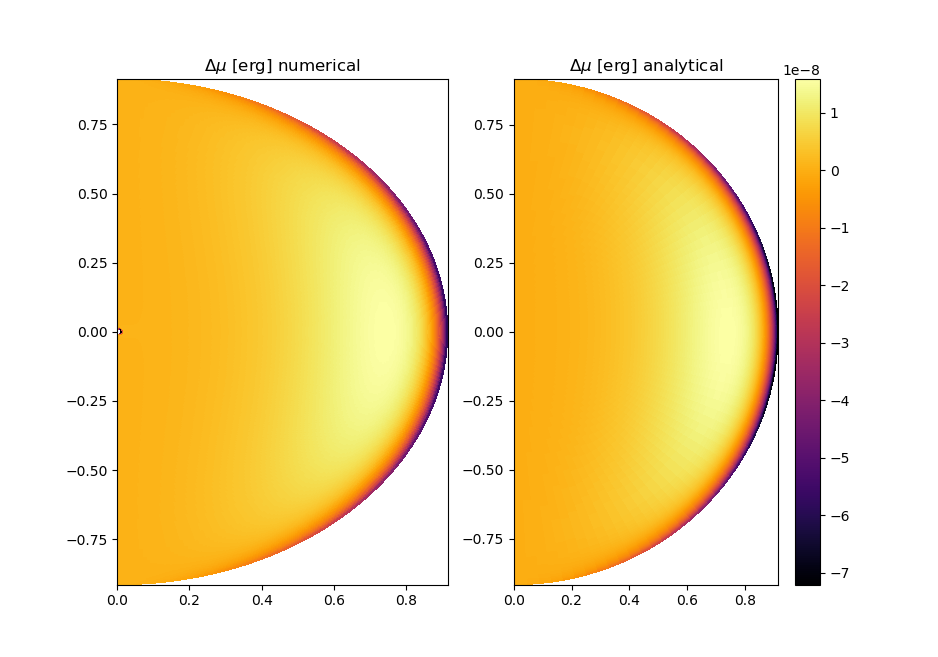

Text(0.5,1,'$\\Delta \\mu$ [erg] analytical')

In [155]:
plt.figure()
plt.subplot(1, 2, 1)
plt.pcolor(x_grid, z_grid, Delta_mu , cmap=cm.inferno,vmin=Delta_mu_min,vmax = Delta_mu_max)
plt.title('$\Delta \mu$ [erg] numerical')


plt.subplot(1, 2, 2)
plt.pcolor(z_analytic_grid,x_analytic_grid,Dmu_analytic_grid,cmap=cm.inferno)
plt.colorbar()
plt.title('$\Delta \mu$ [erg] analytical')

<IPython.core.display.Javascript object>


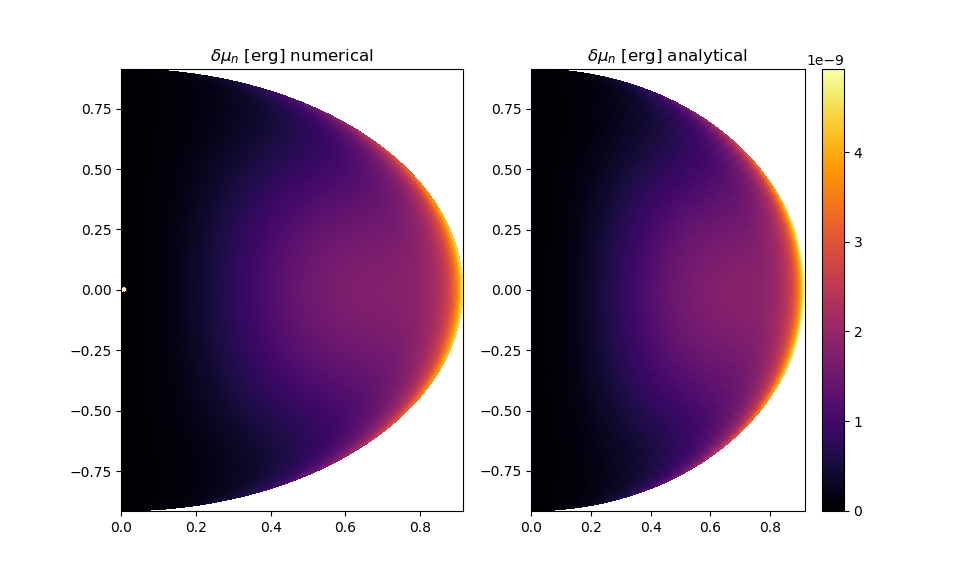

Text(0.5,1,'$\\delta \\mu_n$ [erg] analytical')

In [158]:
plt.figure()
plt.subplot(1, 2, 1)
plt.pcolor(x_grid, z_grid, delta_mu_n , cmap=cm.inferno,vmin=delta_mu_n_min,vmax = delta_mu_n_max)
plt.title('$\delta \mu_n$ [erg] numerical')


plt.subplot(1, 2, 2)
plt.pcolor(z_analytic_grid,x_analytic_grid,dmun_analytic_grid,cmap=cm.inferno)
plt.colorbar()
plt.title('$\delta \mu_n$ [erg] analytical')

# $U_{br}$, $U_{b\theta}$ and $U_{b \phi}$

In [160]:
U_b_analytic = np.loadtxt('rcos_rsin_Ubr_Ubth_Ubphi.dat')

U_b_phi_max = np.max(np.abs(U_b_analytic[:,4]))
U_b_phi_min = np.min(np.abs(U_b_analytic[:,4]))

U_b_r_max = np.max(np.abs(U_b_analytic[:,2]))
U_b_r_min = np.min(np.abs(U_b_analytic[:,2]))

U_b_theta_max = np.max(np.abs(U_b_analytic[:,3]))
U_b_theta_min = np.min(np.abs(U_b_analytic[:,3]))

print(np.shape(U_b_analytic))

(1111, 5)


<IPython.core.display.Javascript object>


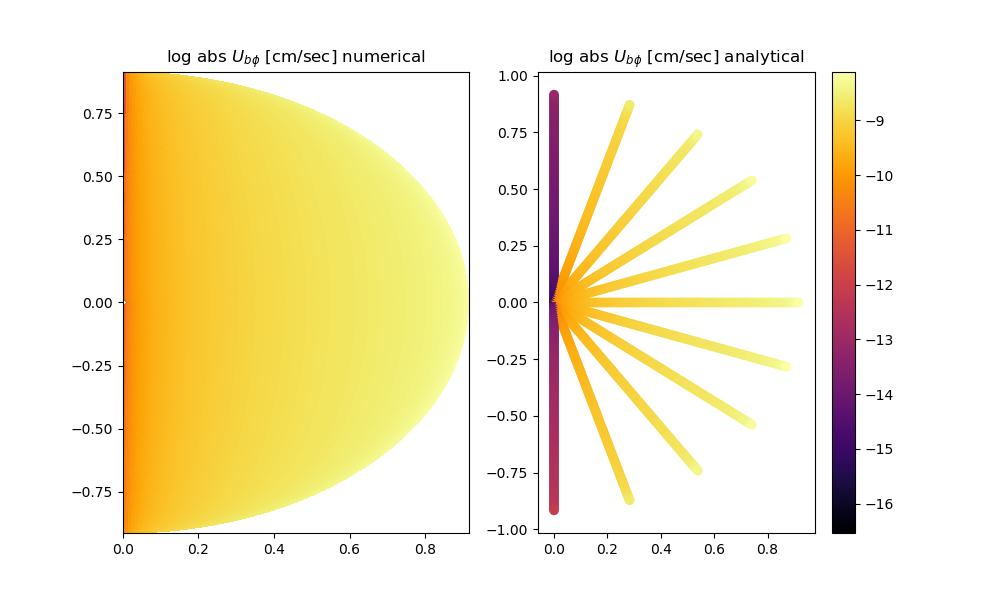

Text(0.5,1,'log abs $ U_{b \\phi}$ [cm/sec] analytical')

In [171]:
plt.figure()
plt.subplot(1, 2, 1)
plt.pcolor(x_grid, z_grid, np.log10(np.abs(U_bphi)) , cmap=cm.inferno, 
           vmax = np.log10(np.abs(U_b_phi_max)), vmin=np.log10(np.abs(U_b_phi_min)))
plt.title('log abs $U_{b \phi}$ [cm/sec] numerical')


plt.subplot(1, 2, 2)
plt.scatter(U_bphi_analytic[:,1],U_b_analytic[:,0],c=np.log10(np.abs(U_b_analytic[:,4])),cmap=cm.inferno)
plt.colorbar()
plt.title('log abs $ U_{b \phi}$ [cm/sec] analytical')

<IPython.core.display.Javascript object>


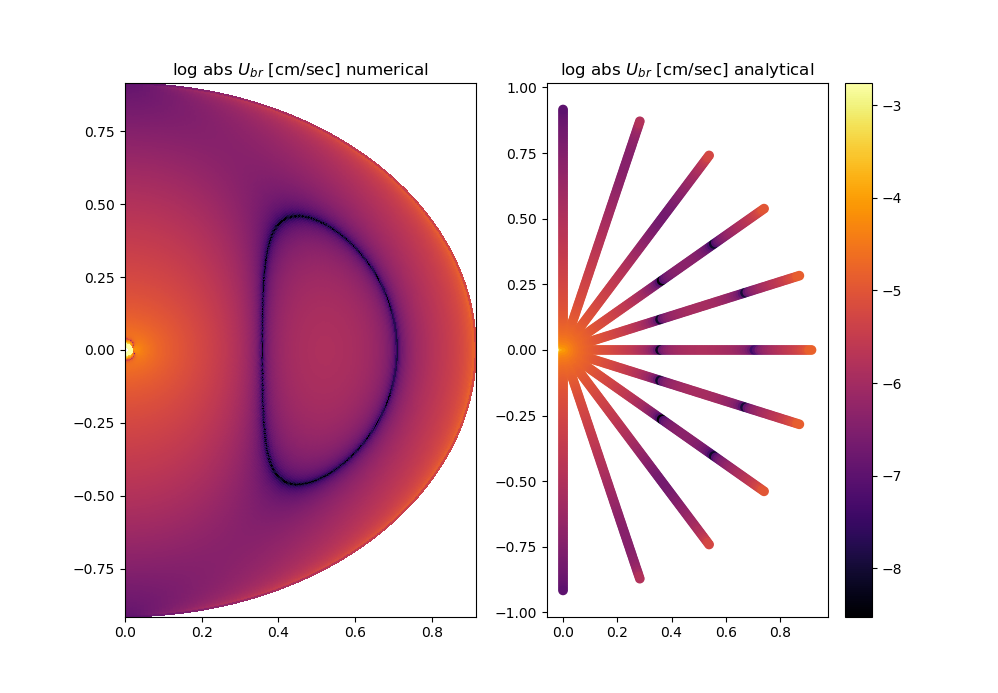

Text(0.5,1,'log abs $U_{b r}$ [cm/sec] analytical')

In [169]:
plt.figure()
plt.subplot(1, 2, 1)
plt.pcolor(x_grid, z_grid, np.log10(np.abs(U_br)) , cmap=cm.inferno, 
           vmax=np.log10(np.abs(U_b_r_max)),
           vmin=np.log10(np.abs(U_b_r_min)))
plt.title('log abs $U_{b r}$ [cm/sec] numerical')

plt.subplot(1, 2, 2)
plt.scatter(U_b_analytic[:,1],U_b_analytic[:,0],c=np.log10(np.abs(U_b_analytic[:,2])),cmap=cm.inferno)
plt.colorbar()
plt.title('log abs $U_{b r}$ [cm/sec] analytical')

<IPython.core.display.Javascript object>


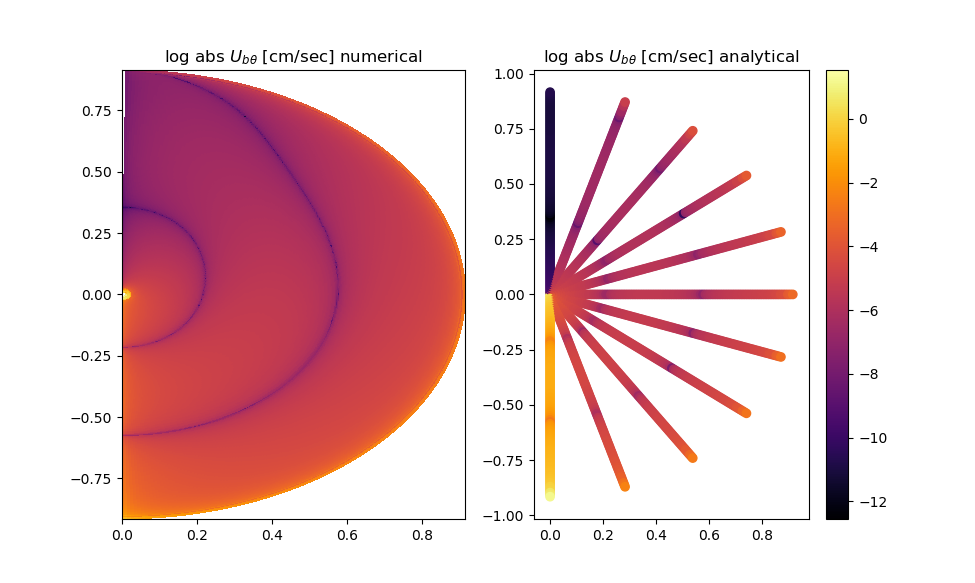

/home/maryhallow/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5,1,'log abs $U_{b \\theta}$ [cm/sec] analytical')

In [170]:
plt.figure()
plt.subplot(1, 2, 1)
plt.pcolor(x_grid, z_grid, np.log10(np.abs(U_btheta)) , cmap=cm.inferno, 
           vmax=np.log10(np.abs(U_b_theta_max)),
           vmin=np.log10(np.abs(U_b_theta_min)))
plt.title('log abs $U_{b \\theta }$ [cm/sec] numerical')

plt.subplot(1, 2, 2)
plt.scatter(U_b_analytic[:,1],U_b_analytic[:,0],c=np.log10(np.abs(U_b_analytic[:,3])),cmap=cm.inferno)
plt.colorbar()
plt.title('log abs $U_{b \\theta}$ [cm/sec] analytical')